In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.signal as signal
import json

### 导入原始数据

In [2]:
ch01_world_dataset = pd.read_table("./data/ch01_world.txt", sep=",", 
                                   names=["FrameIndex_timestamp", "PlayerID", "Coordinate_X", "Coordinate_Y", "X", "Y", "6.1", "7.1", "8.1", "world_x", "world_y"])

In [3]:
ch01_world_dataset

,FrameIndex_timestamp,PlayerID,Coordinate_X,Coordinate_Y,X,Y,6.1,7.1,8.1,world_x,world_y
0,1.0,0.0,2037.0,417.0,2075.0,460.0,1.0,1.0,1.0,31.14,40.80
1,2.0,0.0,2037.0,417.0,2075.0,460.0,1.0,1.0,1.0,31.14,40.80
2,3.0,0.0,2038.0,417.0,2074.0,460.0,1.0,1.0,1.0,31.14,40.80
3,4.0,0.0,2037.0,417.0,2075.0,461.0,1.0,1.0,1.0,31.18,40.90
4,5.0,0.0,2038.0,414.0,2076.0,461.0,1.0,1.0,1.0,31.20,40.91
...,...,...,...,...,...,...,...,...,...,...,...
62495,2496.0,24.0,3331.0,232.0,3370.0,298.0,1.0,1.0,1.0,60.42,26.74
62496,2497.0,24.0,3322.0,235.0,3352.0,299.0,1.0,1.0,1.0,60.07,26.92
62497,2498.0,24.0,3317.0,236.0,3346.0,299.0,1.0,1.0,1.0,59.93,26.94
62498,2499.0,24.0,3314.0,236.0,3339.0,299.0,1.0,1.0,1.0,59.81,26.95


# 球员信息（非球衣号码）
## 红队：2，15，14，22，1，17，0，13，23，9，20
## 蓝队：12，16，11，10，8，18，3，6，5，4，19
## 裁判：7， 24， 21

In [4]:
#将裁判信息删除
ch01_world_dataset = ch01_world_dataset[~ch01_world_dataset['PlayerID'].isin([7.0, 21.0, 24.0])]
ch01_world_dataset

,FrameIndex_timestamp,PlayerID,Coordinate_X,Coordinate_Y,X,Y,6.1,7.1,8.1,world_x,world_y
0,1.0,0.0,2037.0,417.0,2075.0,460.0,1.0,1.0,1.0,31.14,40.80
1,2.0,0.0,2037.0,417.0,2075.0,460.0,1.0,1.0,1.0,31.14,40.80
2,3.0,0.0,2038.0,417.0,2074.0,460.0,1.0,1.0,1.0,31.14,40.80
3,4.0,0.0,2037.0,417.0,2075.0,461.0,1.0,1.0,1.0,31.18,40.90
4,5.0,0.0,2038.0,414.0,2076.0,461.0,1.0,1.0,1.0,31.20,40.91
...,...,...,...,...,...,...,...,...,...,...,...
59995,2496.0,23.0,2936.0,304.0,2966.0,371.0,1.0,1.0,1.0,50.99,35.04
59996,2497.0,23.0,2929.0,303.0,2962.0,378.0,1.0,1.0,1.0,50.89,35.70
59997,2498.0,23.0,2927.0,306.0,2960.0,382.0,1.0,1.0,1.0,50.85,36.09
59998,2499.0,23.0,2922.0,304.0,2957.0,382.0,1.0,1.0,1.0,50.77,36.07


### 将原始数据表切分成away和home两个表格

In [5]:
#切分为home-team数据和away-team数据
away_team = ch01_world_dataset[ch01_world_dataset['PlayerID'].isin([2, 15, 14, 22, 1, 17, 0, 13, 23, 9, 20])].reset_index()
print(away_team)
home_team = ch01_world_dataset[ch01_world_dataset['PlayerID'].isin([12, 16, 11, 10, 8, 18, 3, 6, 5, 4, 19])].reset_index()
print(home_team)

       index  FrameIndex_timestamp  PlayerID  Coordinate_X  Coordinate_Y  \
0          0                   1.0       0.0        2037.0         417.0   
1          1                   2.0       0.0        2037.0         417.0   
2          2                   3.0       0.0        2038.0         417.0   
3          3                   4.0       0.0        2037.0         417.0   
4          4                   5.0       0.0        2038.0         414.0   
...      ...                   ...       ...           ...           ...   
27495  59995                2496.0      23.0        2936.0         304.0   
27496  59996                2497.0      23.0        2929.0         303.0   
27497  59997                2498.0      23.0        2927.0         306.0   
27498  59998                2499.0      23.0        2922.0         304.0   
27499  59999                2500.0      23.0        2917.0         304.0   

            X      Y  6.1  7.1  8.1  world_x  world_y  
0      2075.0  460.0  1.0  1.0 

### 删除原始数据表中不需要的数据，选取每帧球员的坐标

In [6]:
#选取每帧球员的坐标
away_team = pd.DataFrame(away_team, columns=["FrameIndex_timestamp", "PlayerID", "world_x", "world_y"])
away_team = away_team.drop(columns = ["PlayerID"])
away_team = away_team.rename(columns = {"world_x":"x", "world_y":"y"})

home_team = pd.DataFrame(home_team, columns=["FrameIndex_timestamp", "PlayerID", "world_x", "world_y"])
home_team = home_team.drop(columns = ["PlayerID"])
home_team = home_team.rename(columns = {"world_x":"x", "world_y":"y"})

print(away_team)
print(home_team)

       FrameIndex_timestamp      x      y
0                       1.0  31.14  40.80
1                       2.0  31.14  40.80
2                       3.0  31.14  40.80
3                       4.0  31.18  40.90
4                       5.0  31.20  40.91
...                     ...    ...    ...
27495                2496.0  50.99  35.04
27496                2497.0  50.89  35.70
27497                2498.0  50.85  36.09
27498                2499.0  50.77  36.07
27499                2500.0  50.72  36.06

[27500 rows x 3 columns]
       FrameIndex_timestamp       x      y
0                       1.0   76.81  18.79
1                       2.0   76.79  18.79
2                       3.0   76.74  18.98
3                       4.0   76.81  18.79
4                       5.0   76.70  18.99
...                     ...     ...    ...
27495                2496.0  100.32  35.71
27496                2497.0  100.44  35.69
27497                2498.0  100.42  35.70
27498                2499.0  100.44  35.

### 转换表格形式

In [7]:
#拆分获得每帧每个球员的位置坐标表格
j=0
for i in range(0, 27500, 2500):
    home_name='home'+str(j)
    locals()['home'+str(j)] = home_team.loc[i:i+2499].rename(columns={"x":"home_{}_x".format(j), "y":"home_{}_y".format(j)}).set_index("FrameIndex_timestamp")
    away_name='away'+str(j)
    locals()['away'+str(j)] = away_team.loc[i:i+2499].rename(columns={"x":"away_{}_x".format(j), "y":"away_{}_y".format(j)}).set_index("FrameIndex_timestamp")
    j = j+1


#重构表格 合并所有球员位置信息
home_team = pd.concat([home0, home1, home2, home3, home4, home5, home6, home7, home8, home9, home10], axis=1)
away_team = pd.concat([away0, away1, away2, away3, away4, away5, away6, away7, away8, away9, away10], axis=1)
print(home_team)
print(away_team)

                      home_0_x  home_0_y  home_1_x  home_1_y  home_2_x  \
FrameIndex_timestamp                                                     
1.0                      76.81     18.79     69.47     56.76     74.82   
2.0                      76.79     18.79     69.47     56.76     74.82   
3.0                      76.74     18.98     69.47     56.76     74.80   
4.0                      76.81     18.79     69.50     56.72     74.80   
5.0                      76.70     18.99     69.49     56.76     74.80   
...                        ...       ...       ...       ...       ...   
2496.0                   73.67     16.01     63.10     49.06     79.18   
2497.0                   73.64     15.82     62.94     49.18     79.08   
2498.0                   73.64     15.62     62.79     49.35     79.05   
2499.0                   73.60     15.62     62.83     49.05     78.88   
2500.0                   73.65     15.41     62.59     49.52     78.86   

                      home_2_y  home_

### 转换位置坐标（以球场中心为原点）

In [8]:
def change_coordinate(data, field_dimen = (102.0, 69.0)):
    #将坐标系原点从左上移至左下
    y_columns = [c for c in data.columns if c[-1].lower()=='y']
    data[y_columns] = field_dimen[1] - data[y_columns]
    #将坐标系原点移至球场中心
    x_columns = [c for c in data.columns if c[-1].lower()=='x']
    data[x_columns] = data[x_columns] - 0.5*field_dimen[0]
    data[y_columns] = data[y_columns] - 0.5*field_dimen[1]
    return data

In [9]:
#转变坐标系
home_team = change_coordinate(home_team)
away_team = change_coordinate(away_team)
print(home_team)
print(away_team)

                      home_0_x  home_0_y  home_1_x  home_1_y  home_2_x  \
FrameIndex_timestamp                                                     
1.0                      25.81     15.71     18.47    -22.26     23.82   
2.0                      25.79     15.71     18.47    -22.26     23.82   
3.0                      25.74     15.52     18.47    -22.26     23.80   
4.0                      25.81     15.71     18.50    -22.22     23.80   
5.0                      25.70     15.51     18.49    -22.26     23.80   
...                        ...       ...       ...       ...       ...   
2496.0                   22.67     18.49     12.10    -14.56     28.18   
2497.0                   22.64     18.68     11.94    -14.68     28.08   
2498.0                   22.64     18.88     11.79    -14.85     28.05   
2499.0                   22.60     18.88     11.83    -14.55     27.88   
2500.0                   22.65     19.09     11.59    -15.02     27.86   

                      home_2_y  home_

In [10]:
away_team

,away_0_x,away_0_y,away_1_x,away_1_y,away_2_x,away_2_y,away_3_x,away_3_y,away_4_x,away_4_y,...,away_6_x,away_6_y,away_7_x,away_7_y,away_8_x,away_8_y,away_9_x,away_9_y,away_10_x,away_10_y
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,-19.86,-6.30,-34.73,21.48,-46.77,0.55,-10.83,2.63,-12.80,-17.84,...,-33.67,-21.47,-27.07,11.93,-10.17,17.41,-37.37,3.23,-16.20,7.73
2.0,-19.86,-6.30,-34.73,21.48,-46.93,0.71,-10.80,2.62,-12.78,-17.84,...,-33.62,-21.47,-27.17,12.27,-10.16,17.57,-37.41,3.23,-16.19,7.86
3.0,-19.86,-6.30,-34.73,21.48,-46.82,0.56,-10.78,2.62,-12.80,-17.72,...,-33.59,-21.47,-27.06,12.09,-10.13,17.39,-37.44,3.24,-16.17,7.85
4.0,-19.82,-6.40,-34.73,21.48,-46.82,0.56,-10.78,2.74,-12.83,-17.66,...,-33.57,-21.40,-27.08,12.25,-10.08,17.37,-37.44,3.24,-16.17,7.85
5.0,-19.80,-6.41,-34.75,21.49,-46.87,0.57,-10.74,2.61,-12.81,-17.42,...,-33.65,-21.28,-27.05,12.24,-10.02,17.51,-37.39,3.10,-16.10,7.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,-3.44,-16.08,-20.27,6.63,-46.04,-0.80,12.45,-5.22,-5.54,-19.95,...,-10.19,-21.89,-8.38,-1.80,0.86,13.22,-13.77,-4.29,-0.01,-0.54
2497.0,-3.65,-16.32,-20.32,6.51,-45.59,-1.37,12.40,-5.04,-5.76,-19.70,...,-10.20,-22.21,-8.61,-1.13,0.75,13.13,-13.70,-5.00,-0.11,-1.20
2498.0,-3.69,-16.49,-20.42,6.52,-45.32,-1.66,12.33,-5.13,-6.04,-19.70,...,-10.24,-22.30,-8.72,-0.79,0.70,13.00,-13.71,-5.19,-0.15,-1.59


# 绘制球场图

In [11]:
def plot_pitch(field_dimen = (102.0, 69.0), field_color = 'green', linewidth = 2, markersize = 20):
    """ plot_pitch
    
    绘制球场图，所有单位设为米
    
    参数
    -----------
        field_dimen: (length, width) of field in meters. Default is (102,69)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    返回
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    fig, ax = plt.subplots(figsize=(18, 12))
    #选择颜色
    if field_color == 'green':
        ax.set_facecolor('mediumseagreen')
        #线颜色
        lc = 'whitesmoke' 
        #点颜色
        pc = 'w'
    elif field_color == 'white':
        lc = 'k'
        pc = 'k'
    
    border_dimen = (3,3) # 在场地周围包括一个宽度为3米的边界
    meters_per_yard = 0.9144 # 从yard到meter的单位转换
    half_pitch_length = field_dimen[0]/2. # 球场的长
    half_pitch_width = field_dimen[1]/2. # 球场的宽
    signs = [-1,1]
    
    # 足球场的尺寸通常是以码来定义的，所以我们需要转换为米
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    
    # 绘制半场线和中心圆
    ax.plot([0, 0], [-half_pitch_width,half_pitch_width], lc, linewidth = linewidth)
    ax.scatter(0.0, 0.0, marker = 'o', facecolor = lc,linewidth = 0, s = markersize)
    y = np.linspace(-1, 1, 50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2 - y**2)
    ax.plot(x, y, lc, linewidth = linewidth)
    ax.plot(-x, y, lc, linewidth = linewidth)

    for s in signs: # 将每条线单独绘制出来
        # 绘制球场边界
        ax.plot([-half_pitch_length,half_pitch_length], [s*half_pitch_width,s*half_pitch_width], lc, linewidth = linewidth)
        ax.plot([s*half_pitch_length, s*half_pitch_length], [-half_pitch_width,half_pitch_width], lc, linewidth=linewidth)
        # 门柱和线
        ax.plot([s*half_pitch_length, s*half_pitch_length], [-goal_line_width/2., goal_line_width/2.], pc+'s', markersize = 6*markersize/20., linewidth = linewidth)
        # 球门区域
        ax.plot([s*half_pitch_length, s*half_pitch_length-s*box_length], [box_width/2.,box_width/2.], lc, linewidth = linewidth)
        ax.plot([s*half_pitch_length, s*half_pitch_length-s*box_length], [-box_width/2.,-box_width/2.], lc, linewidth = linewidth)
        ax.plot([s*half_pitch_length-s*box_length, s*half_pitch_length-s*box_length], [-box_width/2.,box_width/2.], lc, linewidth = linewidth)
        # 罚球区
        ax.plot([s*half_pitch_length, s*half_pitch_length-s*area_length], [area_width/2., area_width/2.], lc, linewidth = linewidth)
        ax.plot([s*half_pitch_length, s*half_pitch_length-s*area_length], [-area_width/2., -area_width/2.], lc, linewidth = linewidth)
        ax.plot([s*half_pitch_length-s*area_length, s*half_pitch_length-s*area_length], [-area_width/2., area_width/2.], lc, linewidth = linewidth)
        # 罚球点
        ax.scatter(s*half_pitch_length-s*penalty_spot, 0.0, marker = 'o', facecolor = lc, linewidth = 0, s = markersize)
        # 角旗
        y = np.linspace(0, 1, 50)*corner_radius
        x = np.sqrt(corner_radius**2 - y**2)
        ax.plot(s*half_pitch_length-s*x, -half_pitch_width+y, lc, linewidth = linewidth)
        ax.plot(s*half_pitch_length-s*x, half_pitch_width-y, lc, linewidth = linewidth)

        y = np.linspace(-1, 1, 50)*D_length
        x = np.sqrt(D_radius**2 - y**2) + D_pos
        ax.plot(s*half_pitch_length-s*x, y, lc, linewidth = linewidth)
        
    # 删除轴的标签和刻度线
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # 设置轴限值
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax

### 测试：球场绘制功能和球员初始轨迹

/Users/chenke/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  This is separate from the ipykernel package so we can avoid doing imports until


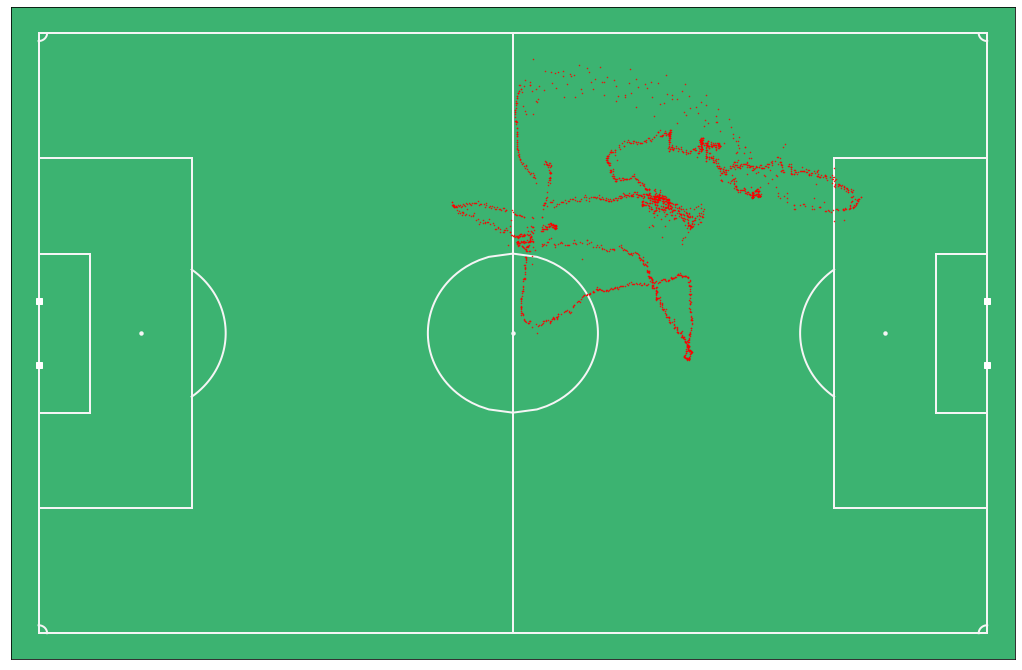

In [12]:
fig, ax = plot_pitch()
#输出100帧内（4s内）所有球员的运动轨迹
ax.plot(home_team['home_0_x'].iloc[:2500], home_team['home_0_y'].iloc[:2500], 'r.', MarkerSize=1)

# 使用卡尔曼滤波算法平滑球员运动轨迹

In [13]:
def get_D(ob_list):
    sz = len(ob_list)
    s = 0
    for i in range(0, sz):
        s = s + ob_list[i]
    avg = s / sz
    s1 = 0
    for i in range(0, sz):
        s1 = s1 + (ob_list[i] - avg) ** 2
    s2 = np.sqrt(s1 / sz)
    return s2

In [14]:
#平滑球员运动轨迹，消除噪点
#参数(球员x坐标数组：arryas, 球员y坐标数组：arrays，均方误差：float)
def smoothTrajectory(player_x, player_y, q):
    sz = 2500  # 数组长度
    position_x = player_x  # 观察值列表
    position_y = player_y
    Q = q  # （模型预测均方误差） 误差越大，滤波曲线越贴近观察值；反之贴近模型预测值

    x_pst = np.zeros(sz)
    err_pst = np.zeros(sz)
    x_pri = np.zeros(sz)
    err_pri = np.zeros(sz)
    K = np.zeros(sz)

    D = get_D(position_x)  # 观察值均方误差
    x_pst[0] = position_x[0]
    err_pst[0] = 0

    for cnt in range(1, sz):
        x_pri[cnt] = x_pst[cnt - 1]
        err_pri[cnt] = err_pst[cnt - 1] + Q

        K[cnt] = err_pri[cnt] / (err_pri[cnt] + D)
        x_pst[cnt] = x_pri[cnt] + K[cnt] * (position_x[cnt] - x_pri[cnt])
        err_pst[cnt] = (1 - K[cnt]) * err_pri[cnt]
    

    x_pst_y = np.zeros(sz)
    err_pst_y = np.zeros(sz)
    x_pri_y = np.zeros(sz)
    err_pri_y = np.zeros(sz)
    K_y = np.zeros(sz)

    D_y = get_D(position_y)  # 观察值均方误差
    x_pst_y[0] = position_y[0]
    err_pst[0] = 0

    for cnt in range(1, sz):
        x_pri_y[cnt] = x_pst_y[cnt - 1]
        err_pri_y[cnt] = err_pst_y[cnt - 1] + Q

        K_y[cnt] = err_pri_y[cnt] / (err_pri_y[cnt] + D_y)
        x_pst_y[cnt] = x_pri_y[cnt] + K_y[cnt] * (position_y[cnt] - x_pri_y[cnt])
        err_pst_y[cnt] = (1 - K_y[cnt]) * err_pri_y[cnt]
    return x_pst, x_pst_y

In [15]:
#对每个home-team球员调用卡尔曼滤波算法来平滑运动轨迹，参数设为0.1
home_0_x, home_0_y = smoothTrajectory(home_team['home_0_x'].iloc[:2500].values, home_team['home_0_y'].iloc[:2500].values, 0.1)
home_team['home_0_x'] = home_0_x
home_team['home_0_y'] = home_0_y
home_1_x, home_1_y = smoothTrajectory(home_team['home_1_x'].iloc[:2500].values, home_team['home_1_y'].iloc[:2500].values, 0.1)
home_team['home_1_x'] = home_1_x
home_team['home_1_y'] = home_1_y
home_2_x, home_2_y = smoothTrajectory(home_team['home_2_x'].iloc[:2500].values, home_team['home_2_y'].iloc[:2500].values, 0.1)
home_team['home_2_x'] = home_2_x
home_team['home_2_y'] = home_2_y
home_3_x, home_3_y = smoothTrajectory(home_team['home_3_x'].iloc[:2500].values, home_team['home_3_y'].iloc[:2500].values, 0.1)
home_team['home_3_x'] = home_3_x
home_team['home_3_y'] = home_3_y
home_4_x, home_4_y = smoothTrajectory(home_team['home_4_x'].iloc[:2500].values, home_team['home_4_y'].iloc[:2500].values, 0.1)
home_team['home_4_x'] = home_4_x
home_team['home_4_y'] = home_4_y
home_5_x, home_5_y = smoothTrajectory(home_team['home_5_x'].iloc[:2500].values, home_team['home_5_y'].iloc[:2500].values, 0.1)
home_team['home_5_x'] = home_5_x
home_team['home_5_y'] = home_5_y
home_6_x, home_6_y = smoothTrajectory(home_team['home_6_x'].iloc[:2500].values, home_team['home_6_y'].iloc[:2500].values, 0.1)
home_team['home_6_x'] = home_6_x
home_team['home_6_y'] = home_6_y
home_7_x, home_7_y = smoothTrajectory(home_team['home_7_x'].iloc[:2500].values, home_team['home_7_y'].iloc[:2500].values, 0.1)
home_team['home_7_x'] = home_7_x
home_team['home_7_y'] = home_7_y
home_8_x, home_8_y = smoothTrajectory(home_team['home_8_x'].iloc[:2500].values, home_team['home_8_y'].iloc[:2500].values, 0.1)
home_team['home_8_x'] = home_8_x
home_team['home_8_y'] = home_8_y
home_9_x, home_9_y = smoothTrajectory(home_team['home_9_x'].iloc[:2500].values, home_team['home_9_y'].iloc[:2500].values, 0.1)
home_team['home_9_x'] = home_9_x
home_team['home_9_y'] = home_9_y
home_10_x, home_10_y = smoothTrajectory(home_team['home_10_x'].iloc[:2500].values, home_team['home_10_y'].iloc[:2500].values, 0.1)
home_team['home_10_x'] = home_10_x
home_team['home_10_y'] = home_10_y

In [16]:
home_team

,home_0_x,home_0_y,home_1_x,home_1_y,home_2_x,home_2_y,home_3_x,home_3_y,home_4_x,home_4_y,...,home_6_x,home_6_y,home_7_x,home_7_y,home_8_x,home_8_y,home_9_x,home_9_y,home_10_x,home_10_y
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,25.810000,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.800000,5.590000,14.660000,-2.130000,...,11.320000,-0.190000,-0.250000,1.480000,18.150000,17.170000,13.580000,-12.010000,49.670000,0.130000
2.0,25.809793,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.799795,5.590000,14.660137,-2.130000,...,11.320125,-0.190000,-0.249855,1.479113,18.149468,17.166186,13.580000,-12.010000,49.667083,0.129606
3.0,25.808373,15.704757,18.470000,-22.260000,23.819443,-7.060000,25.797012,5.590000,14.659058,-2.131955,...,11.319876,-0.190000,-0.248441,1.482154,18.149479,17.166327,13.579362,-12.011234,49.659466,0.128892
4.0,25.808422,15.704967,18.470905,-22.258916,23.818654,-7.060000,25.792596,5.589662,14.657920,-2.134770,...,11.320240,-0.190000,-0.245615,1.488916,18.149495,17.166524,13.578445,-12.013020,49.647568,0.127972
5.0,25.804221,15.694892,18.471653,-22.258955,23.817681,-7.060000,25.785144,5.589240,14.659033,-2.134592,...,11.320692,-0.190000,-0.238423,1.493853,18.150710,17.167440,13.577295,-12.015283,49.608269,0.106775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,23.456214,18.889443,13.381226,-13.647071,28.709396,5.206702,21.727097,5.417630,21.255567,-0.637279,...,-7.484108,11.915060,-6.349744,-15.909793,6.002143,18.664769,-3.370500,-17.351098,49.148083,-1.159213
2497.0,23.376970,18.865857,13.240580,-13.742604,28.638184,5.159796,21.668213,5.338358,21.188243,-0.720368,...,-7.515592,11.868677,-6.519830,-16.191605,5.935953,18.558803,-3.585773,-17.456947,49.202935,-1.164847
2498.0,23.305419,18.867450,13.099021,-13.845024,28.571635,5.116240,21.618609,5.268304,21.125069,-0.796499,...,-7.547983,11.842312,-6.679636,-16.484465,5.870374,18.440608,-3.799530,-17.538721,49.243723,-1.171280


In [17]:
#对每个away-team球员调用卡尔曼滤波算法来平滑运动轨迹，参数设为0.1
away_0_x, away_0_y = smoothTrajectory(away_team['away_0_x'].iloc[:2500].values, away_team['away_0_y'].iloc[:2500].values, 0.1)
away_team['away_0_x'] = away_0_x
away_team['away_0_y'] = away_0_y
away_1_x, away_1_y = smoothTrajectory(away_team['away_1_x'].iloc[:2500].values, away_team['away_1_y'].iloc[:2500].values, 0.1)
away_team['away_1_x'] = away_1_x
away_team['away_1_y'] = away_1_y
away_2_x, away_2_y = smoothTrajectory(away_team['away_2_x'].iloc[:2500].values, away_team['away_2_y'].iloc[:2500].values, 0.1)
away_team['away_2_x'] = away_2_x
away_team['away_2_y'] = away_2_y
away_3_x, away_3_y = smoothTrajectory(away_team['away_3_x'].iloc[:2500].values, away_team['away_3_y'].iloc[:2500].values, 0.1)
away_team['away_3_x'] = away_3_x
away_team['away_3_y'] = away_3_y
away_4_x, away_4_y = smoothTrajectory(away_team['away_4_x'].iloc[:2500].values, away_team['away_4_y'].iloc[:2500].values, 0.1)
away_team['away_4_x'] = away_4_x
away_team['away_4_y'] = away_4_y
away_5_x, away_5_y = smoothTrajectory(away_team['away_5_x'].iloc[:2500].values, away_team['away_5_y'].iloc[:2500].values, 0.1)
away_team['away_5_x'] = away_5_x
away_team['away_5_y'] = away_5_y
away_6_x, away_6_y = smoothTrajectory(away_team['away_6_x'].iloc[:2500].values, away_team['away_6_y'].iloc[:2500].values, 0.1)
away_team['away_6_x'] = away_6_x
away_team['away_6_y'] = away_6_y
away_7_x, away_7_y = smoothTrajectory(away_team['away_7_x'].iloc[:2500].values, away_team['away_7_y'].iloc[:2500].values, 0.1)
away_team['away_7_x'] = away_7_x
away_team['away_7_y'] = away_7_y
away_8_x, away_8_y = smoothTrajectory(away_team['away_8_x'].iloc[:2500].values, away_team['away_8_y'].iloc[:2500].values, 0.1)
away_team['away_8_x'] = away_8_x
away_team['away_8_y'] = away_8_y
away_9_x, away_9_y = smoothTrajectory(away_team['away_9_x'].iloc[:2500].values, away_team['away_9_y'].iloc[:2500].values, 0.1)
away_team['away_9_x'] = away_9_x
away_team['away_9_y'] = away_9_y
away_10_x, away_10_y = smoothTrajectory(away_team['away_10_x'].iloc[:2500].values, away_team['away_10_y'].iloc[:2500].values, 0.1)
away_team['away_10_x'] = away_10_x
away_team['away_10_y'] = away_10_y

In [18]:
away_team

,away_0_x,away_0_y,away_1_x,away_1_y,away_2_x,away_2_y,away_3_x,away_3_y,away_4_x,away_4_y,...,away_6_x,away_6_y,away_7_x,away_7_y,away_8_x,away_8_y,away_9_x,away_9_y,away_10_x,away_10_y
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,-19.860000,-6.300000,-34.730000,21.480000,-46.770000,0.550000,-10.830000,2.630000,-12.800000,-17.840000,...,-33.670000,-21.470000,-27.070000,11.930000,-10.170000,17.410000,-37.370000,3.230000,-16.200000,7.730000
2.0,-19.860000,-6.300000,-34.730000,21.480000,-46.775249,0.557824,-10.829680,2.629928,-12.799804,-17.840000,...,-33.669231,-21.470000,-27.071066,11.932801,-10.169912,17.411197,-37.370612,3.230000,-16.199897,7.731196
3.0,-19.860000,-6.300000,-34.730000,21.480000,-46.778049,0.558022,-10.828637,2.629786,-12.799808,-17.838000,...,-33.666849,-21.470000,-27.070834,11.935360,-10.169218,17.410884,-37.372689,3.230243,-16.199288,7.733353
4.0,-19.858626,-6.302090,-34.730000,21.480000,-46.781740,0.558269,-10.827138,2.632111,-12.800665,-17.833629,...,-33.662617,-21.467847,-27.071116,11.942910,-10.166936,17.409990,-37.375617,3.230589,-16.198413,7.736469
5.0,-19.856024,-6.305039,-34.731180,21.480456,-46.791331,0.560026,-10.823659,2.631501,-12.801010,-17.820391,...,-33.661911,-21.460359,-27.070274,11.952206,-10.162040,17.412846,-37.376419,3.224607,-16.194600,7.740066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,-1.974834,-14.833724,-20.149635,7.654563,-45.744347,-0.813297,13.314885,-4.214702,-3.595334,-18.383093,...,-9.864389,-20.932522,-7.977903,0.419069,1.404756,13.203068,-13.614186,-2.929141,0.343069,-0.777635
2497.0,-2.149196,-14.954596,-20.170198,7.533753,-45.718417,-0.926022,13.224687,-4.282127,-3.800328,-18.499097,...,-9.903795,-21.058367,-8.040210,0.284165,1.345891,13.196993,-13.624239,-3.148235,0.299078,-0.816426
2498.0,-2.309572,-15.079463,-20.200349,7.426750,-45.651485,-1.074642,13.136479,-4.351395,-4.012425,-18.604883,...,-9.943271,-21.180681,-8.107219,0.190620,1.287822,13.180615,-13.634286,-3.364251,0.255475,-0.887473


### 测试：选取away-team球员9的运动轨迹 来测试卡尔曼滤波平滑效果

/Users/chenke/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


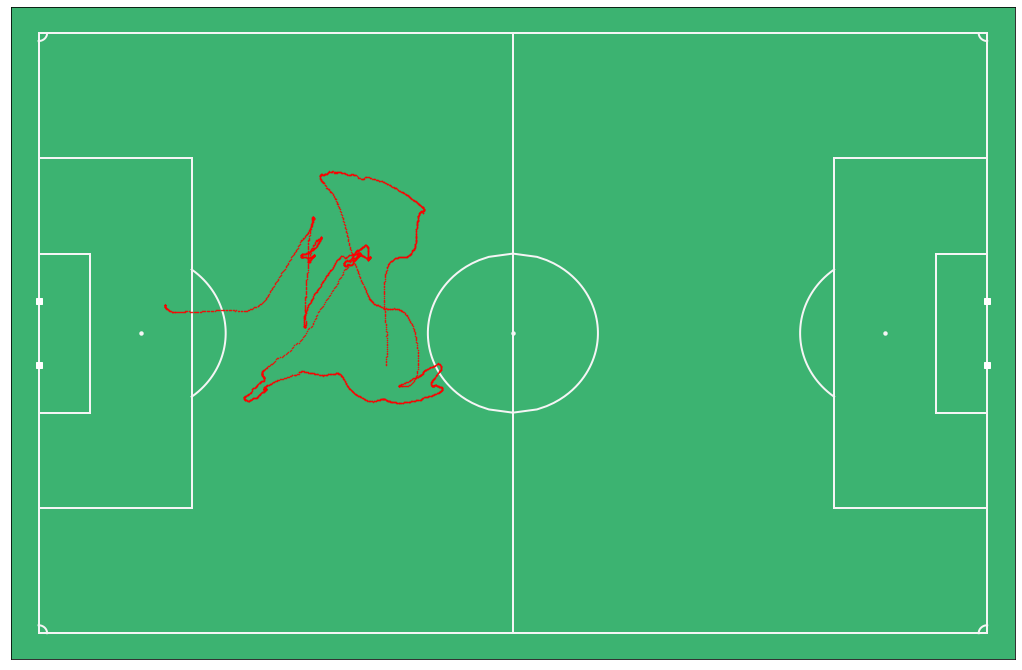

In [19]:
fig, ax = plot_pitch()
ax.plot(away_team['away_9_x'].iloc[:2500], away_team['away_9_y'].iloc[:2500], 'r.', MarkerSize=1)

### 计算球员在每一帧的速度和加速度

In [20]:
def remove_player_velocities(team):
    
    columns = [c for c in team.columns if c.split('_')[-1] in ['vx','vy','ax','ay','speed','acceleration']]
    team = team.drop(columns=columns)
    return team

In [21]:
def calc_player_velocities(team):
    team = remove_player_velocities(team)
    player_ids = np.unique( [ c[:-2] for c in team.columns if c[:4] in ['home','away'] ] )
    dt = 0.04 #每帧间隔0.04s
    
    #估计团队中球员的速度
    for player in player_ids:
        vx = team[player+"_x"].diff() / dt
        vy = team[player+'_y'].diff() / dt
        
        #使用Savitzky_Golay滤波器平滑数据点
        vx.loc[1] = 0
        vy.loc[1] = 0
        vx.loc[:] = signal.savgol_filter(vx.loc[:], window_length=7, polyorder=1)
        vy.loc[:] = signal.savgol_filter(vy.loc[:], window_length=7, polyorder=1)
        
        team[player + "_vx"] = vx
        team[player + "_vy"] = vy
        team[player + "_speed"] = np.sqrt(vx**2 + vy**2)
    
    return team

In [22]:
home_team = calc_player_velocities(home_team)
home_team

,home_0_x,home_0_y,home_1_x,home_1_y,home_2_x,home_2_y,home_3_x,home_3_y,home_4_x,home_4_y,...,home_6_speed,home_7_vx,home_7_vy,home_7_speed,home_8_vx,home_8_vy,home_8_speed,home_9_vx,home_9_vy,home_9_speed
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,25.810000,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.800000,5.590000,14.660000,-2.130000,...,0.029780,-0.053176,-0.014279,0.055060,-0.019430,-0.136229,0.137608,-0.001618,-0.002677,0.003128
2.0,25.809793,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.799795,5.590000,14.660137,-2.130000,...,0.012332,0.007249,0.024982,0.026012,-0.006175,-0.054347,0.054697,-0.005983,-0.011502,0.012965
3.0,25.808373,15.704757,18.470000,-22.260000,23.819443,-7.060000,25.797012,5.590000,14.659058,-2.131955,...,0.006084,0.067674,0.064243,0.093311,0.007081,0.027534,0.028430,-0.010349,-0.020327,0.022810
4.0,25.808422,15.704967,18.470905,-22.258916,23.818654,-7.060000,25.792596,5.589662,14.657920,-2.134770,...,0.023274,0.128099,0.103505,0.164690,0.020336,0.109416,0.111290,-0.014714,-0.029152,0.032655
5.0,25.804221,15.694892,18.471653,-22.258955,23.817681,-7.060000,25.785144,5.589240,14.659033,-2.134592,...,0.019907,0.189426,0.140488,0.235837,0.023517,0.169469,0.171092,-0.011532,-0.027588,0.029901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,23.456214,18.889443,13.381226,-13.647071,28.709396,5.206702,21.727097,5.417630,21.255567,-0.637279,...,1.189689,-3.715461,-7.329962,8.217846,-1.558138,-1.784935,2.369344,-5.359015,-3.426109,6.360603
2497.0,23.376970,18.865857,13.240580,-13.742604,28.638184,5.159796,21.668213,5.338358,21.188243,-0.720368,...,1.181004,-3.739784,-7.350771,8.247412,-1.573515,-1.947607,2.503821,-5.234796,-3.465141,6.277761
2498.0,23.305419,18.867450,13.099021,-13.845024,28.571635,5.116240,21.618609,5.268304,21.125069,-0.796499,...,1.132425,-3.803364,-7.346362,8.272521,-1.581715,-2.060955,2.597953,-5.124403,-3.514782,6.213952


In [23]:
away_team = calc_player_velocities(away_team)
away_team

,away_0_x,away_0_y,away_1_x,away_1_y,away_2_x,away_2_y,away_3_x,away_3_y,away_4_x,away_4_y,...,away_6_speed,away_7_vx,away_7_vy,away_7_speed,away_8_vx,away_8_vy,away_8_speed,away_9_vx,away_9_vy,away_9_speed
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,-19.860000,-6.300000,-34.730000,21.480000,-46.770000,0.550000,-10.830000,2.630000,-12.800000,-17.840000,...,0.086039,-0.045423,0.046432,0.064955,-0.050924,0.033754,0.061095,0.004780,0.027719,0.028128
2.0,-19.860000,-6.300000,-34.730000,21.480000,-46.775249,0.557824,-10.829680,2.629928,-12.799804,-17.840000,...,0.040111,-0.016225,0.068280,0.070181,-0.000055,0.016736,0.016736,-0.019978,0.004977,0.020589
3.0,-19.860000,-6.300000,-34.730000,21.480000,-46.778049,0.558022,-10.828637,2.629786,-12.799808,-17.838000,...,0.069617,0.012972,0.090128,0.091057,0.050814,-0.000282,0.050814,-0.044736,-0.017765,0.048134
4.0,-19.858626,-6.302090,-34.730000,21.480000,-46.781740,0.558269,-10.827138,2.632111,-12.800665,-17.833629,...,0.130826,0.042170,0.111977,0.119654,0.101682,-0.017300,0.103143,-0.069494,-0.040507,0.080438
5.0,-19.856024,-6.305039,-34.731180,21.480456,-46.791331,0.560026,-10.823659,2.631501,-12.801010,-17.820391,...,0.205541,0.077406,0.127812,0.149424,0.162507,-0.065761,0.175309,-0.090596,-0.067870,0.113199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,-1.974834,-14.833724,-20.149635,7.654563,-45.744347,-0.813297,13.314885,-4.214702,-3.595334,-18.383093,...,2.896909,-1.359442,-4.313276,4.522436,-1.428762,-0.149316,1.436543,-0.438982,-4.512437,4.533739
2497.0,-2.149196,-14.954596,-20.170198,7.533753,-45.718417,-0.926022,13.224687,-4.282127,-3.800328,-18.499097,...,2.865752,-1.355695,-4.444616,4.646776,-1.403058,-0.136902,1.409721,-0.483786,-4.329752,4.356696
2498.0,-2.309572,-15.079463,-20.200349,7.426750,-45.651485,-1.074642,13.136479,-4.351395,-4.012425,-18.604883,...,2.872044,-1.445747,-4.072107,4.321139,-1.387431,-0.128514,1.393370,-0.496320,-4.254150,4.283004


### 绘制任意一帧的球场图

In [24]:
def plot_frame(home_team, away_team, figax, field_dimen = (102.0, 69.0)):
    """
    plot_frame(home_team, away_team)
    
    绘制一帧主队和客队的图
    
    参数
    ----------
        home_team:row of the home team data
        away_team:row of the away team data
        figax: Can be used to pass in the (fig,ax) objects of a previously generated pitch.
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (102.0, 69.0)
    """
    
    figax = figax
    #按顺序绘制主客队
    for team, color in list(zip([home_team, away_team], ('r', 'b'))):
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x']
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y']
        figax.plot(team[x_columns], team[y_columns], color+'o', MarkerSize=10, alpha=0.7)
        
        #使用箭头表示速度
        vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns]
        vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns]
        ax.quiver(team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color = color, scale_units='inches', scale=10, width=0.0015, headlength=5, headwidth=3, alpha=0.7)
    
        #添加注释(不是球衣号码)
        [ax.text(team[x]+0.5, team[y]+0.5, x.split("_")[1], fontsize=10, color=color) for x, y in zip(x_columns, y_columns)]
    return figax

/Users/chenke/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/chenke/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


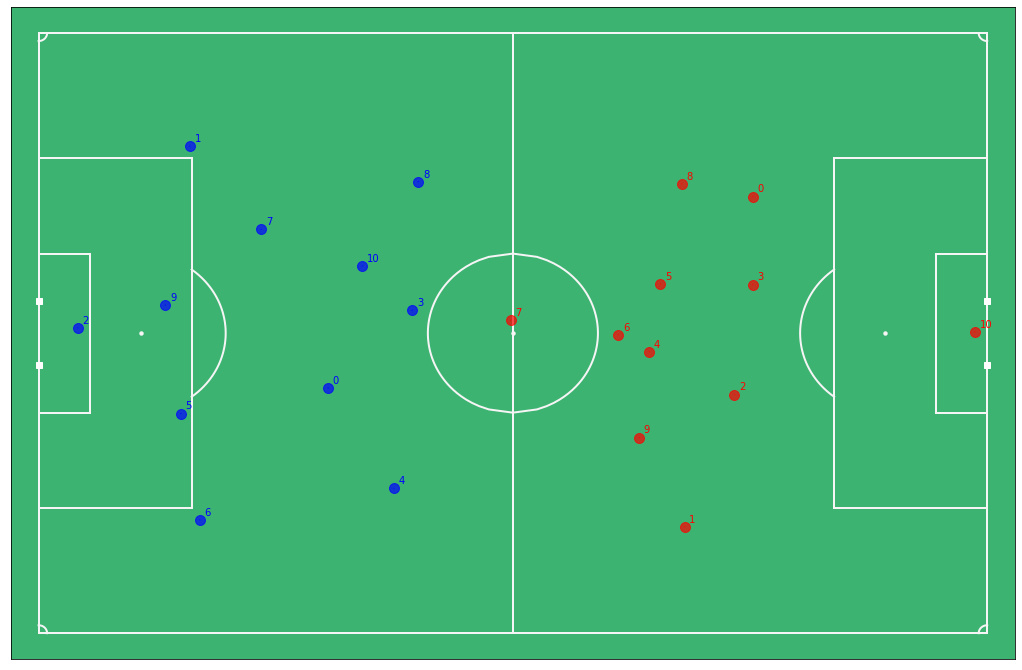

In [25]:
fig, ax = plot_pitch()
ax = plot_frame(home_team.loc[1], away_team.loc[1], ax)

### 读取原始数据

In [26]:
with open("./data/100-s-1.json", encoding='utf-8-sig') as load_f:
    load_dict = json.load(load_f)
    print(load_dict)

{'field_name': 'zijingangWest—2021-03-10', 'game_id': '1', 'half_time': 45, 'half_id': 'First', 'four_officials_report': {'home': {'home_or_away': 'Home', 'team_id': None, 'team_name': 'home_team', 'players': [{'name': None, 'num': '7', 'PlayerID': None, 'IsStarting': None, 'IsPlayerkeeper': None, 'playing_time': None}, {'name': None, 'num': '6', 'PlayerID': None, 'IsStarting': None, 'IsPlayerkeeper': None, 'playing_time': None}, {'name': None, 'num': '5', 'PlayerID': None, 'IsStarting': None, 'IsPlayerkeeper': None, 'playing_time': None}, {'name': None, 'num': '8', 'PlayerID': None, 'IsStarting': None, 'IsPlayerkeeper': None, 'playing_time': None}, {'name': None, 'num': '0', 'PlayerID': None, 'IsStarting': None, 'IsPlayerkeeper': None, 'playing_time': None}, {'name': None, 'num': '4', 'PlayerID': None, 'IsStarting': None, 'IsPlayerkeeper': None, 'playing_time': None}, {'name': None, 'num': '2', 'PlayerID': None, 'IsStarting': None, 'IsPlayerkeeper': None, 'playing_time': None}, {'name

### 将原始json格式文件转换成dataframe

In [27]:
frames=[]
for i in load_dict['data']:
    element = pd.DataFrame(i, index=[0])
    frames.append(element)
data_df = pd.concat(frames)
data_df = data_df.drop(columns = ["teamID","name","PlayerID","IsStarting","IsPlayerkeeper","image_x","image_y","channel"
                                 ,"possessChangeNums","isGetFromLast"])
data_df = data_df.reset_index()
#改变位置坐标 以中心为原点
data_df = change_coordinate(data_df)
#换算action_time为action_frame,与球员位置信息对应
data_df = data_df.rename(columns={"action_time":"action_frame","world_x":"ball_x", "world_y":"ball_y"})
data_df['action_frame'] = data_df['action_frame'].map(lambda x: round(x/0.04))
data_df.loc[0, 'action_frame'] = 1

data_df

,index,team,teamType,num,ball_x,ball_y,action,isHand,isPass,action_frame
0,-51.0,home_team,Home,7,-0.405092,1.790302,HandSupport,True,False,1
1,-51.0,home_team,Home,7,-0.308662,1.324223,PassSucceeded,False,True,18
2,-51.0,home_team,Home,4,15.560114,-2.901493,CatchSucceeded,True,False,35
3,-51.0,home_team,Home,4,11.642454,-1.387128,PassSucceeded,False,True,100
4,-51.0,home_team,Home,5,10.805860,10.766103,CatchSucceeded,True,False,118
5,-51.0,home_team,Home,5,6.278050,14.206220,PassSucceeded,False,True,213
6,-51.0,home_team,Home,4,1.561997,4.277013,CatchSucceeded,True,False,236
7,-51.0,home_team,Home,4,3.032148,5.707636,PassFailed,False,True,260
8,-51.0,away_team,Away,7,-11.896450,11.827184,Break2,True,True,294
9,-51.0,home_team,Home,4,-1.122416,5.234544,HandLose,True,False,325


In [28]:
#合并home-team和away-team表格，并且新增两列卫ball-x和ball-y
sum_df = pd.concat([home_team, away_team], axis=1)
sum_df['ball_x']=np.nan
sum_df['ball_y']=np.nan
sum_df

,home_0_x,home_0_y,home_1_x,home_1_y,home_2_x,home_2_y,home_3_x,home_3_y,home_4_x,home_4_y,...,away_7_vy,away_7_speed,away_8_vx,away_8_vy,away_8_speed,away_9_vx,away_9_vy,away_9_speed,ball_x,ball_y
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,25.810000,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.800000,5.590000,14.660000,-2.130000,...,0.046432,0.064955,-0.050924,0.033754,0.061095,0.004780,0.027719,0.028128,NaN,NaN
2.0,25.809793,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.799795,5.590000,14.660137,-2.130000,...,0.068280,0.070181,-0.000055,0.016736,0.016736,-0.019978,0.004977,0.020589,NaN,NaN
3.0,25.808373,15.704757,18.470000,-22.260000,23.819443,-7.060000,25.797012,5.590000,14.659058,-2.131955,...,0.090128,0.091057,0.050814,-0.000282,0.050814,-0.044736,-0.017765,0.048134,NaN,NaN
4.0,25.808422,15.704967,18.470905,-22.258916,23.818654,-7.060000,25.792596,5.589662,14.657920,-2.134770,...,0.111977,0.119654,0.101682,-0.017300,0.103143,-0.069494,-0.040507,0.080438,NaN,NaN
5.0,25.804221,15.694892,18.471653,-22.258955,23.817681,-7.060000,25.785144,5.589240,14.659033,-2.134592,...,0.127812,0.149424,0.162507,-0.065761,0.175309,-0.090596,-0.067870,0.113199,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,23.456214,18.889443,13.381226,-13.647071,28.709396,5.206702,21.727097,5.417630,21.255567,-0.637279,...,-4.313276,4.522436,-1.428762,-0.149316,1.436543,-0.438982,-4.512437,4.533739,NaN,NaN
2497.0,23.376970,18.865857,13.240580,-13.742604,28.638184,5.159796,21.668213,5.338358,21.188243,-0.720368,...,-4.444616,4.646776,-1.403058,-0.136902,1.409721,-0.483786,-4.329752,4.356696,NaN,NaN
2498.0,23.305419,18.867450,13.099021,-13.845024,28.571635,5.116240,21.618609,5.268304,21.125069,-0.796499,...,-4.072107,4.321139,-1.387431,-0.128514,1.393370,-0.496320,-4.254150,4.283004,NaN,NaN


# 添加球的轨迹坐标

In [29]:
sum_df.loc[1:18, "ball_x"] = sum_df.loc[1:18, "home_7_x"]
sum_df.loc[1:18, "ball_y"] = sum_df.loc[1:18, "home_7_y"]

sum_df.loc[18:35,"ball_x"] = np.linspace(sum_df.loc[18, "home_7_x"], sum_df.loc[35, "home_4_x"], (35-18+1))
sum_df.loc[18:35,"ball_y"] = np.linspace(sum_df.loc[18, "home_7_y"], sum_df.loc[35, "home_4_y"], (35-18+1))

sum_df.loc[35:100, 'ball_x'] = sum_df.loc[35:100, "home_4_x"]
sum_df.loc[35:100, 'ball_y'] = sum_df.loc[35:100, "home_4_y"]

sum_df.loc[100:118,"ball_x"] = np.linspace(sum_df.loc[100, "home_4_x"], sum_df.loc[118, "home_5_x"], (118-100+1))
sum_df.loc[100:118,"ball_y"] = np.linspace(sum_df.loc[100, "home_4_y"], sum_df.loc[118, "home_5_y"], (118-100+1))

sum_df.loc[118:213, 'ball_x'] = sum_df.loc[118:213, "home_5_x"]
sum_df.loc[118:213, 'ball_y'] = sum_df.loc[118:213, "home_5_y"]

sum_df.loc[213:236,"ball_x"] = np.linspace(sum_df.loc[213, "home_5_x"], sum_df.loc[236, "home_4_x"], (236-213+1))
sum_df.loc[213:236,"ball_y"] = np.linspace(sum_df.loc[213, "home_5_y"], sum_df.loc[236, "home_4_y"], (236-213+1))

sum_df.loc[236:260, 'ball_x'] = sum_df.loc[236:260, "home_4_x"]
sum_df.loc[236:260, 'ball_y'] = sum_df.loc[236:260, "home_4_y"]

sum_df.loc[260:294,"ball_x"] = np.linspace(sum_df.loc[260, "home_4_x"], sum_df.loc[294, "away_7_x"], (294-260+1))
sum_df.loc[260:294,"ball_y"] = np.linspace(sum_df.loc[260, "home_4_y"], sum_df.loc[294, "away_7_y"], (294-260+1))

sum_df.loc[294:325,"ball_x"] = np.linspace(sum_df.loc[294, "away_7_x"], sum_df.loc[325, "home_4_x"], (325-294+1))
sum_df.loc[294:325,"ball_y"] = np.linspace(sum_df.loc[294, "away_7_y"], sum_df.loc[325, "home_4_y"], (325-294+1))

sum_df.loc[325:337,"ball_x"] = np.linspace(sum_df.loc[325, "home_4_x"], sum_df.loc[294, "away_10_x"], (337-325+1))
sum_df.loc[325:337,"ball_y"] = np.linspace(sum_df.loc[325, "home_4_y"], sum_df.loc[294, "away_10_y"], (337-325+1))

sum_df.loc[337:384,"ball_x"] = np.linspace(sum_df.loc[337, "away_10_x"], sum_df.loc[384, "home_4_x"], (384-337+1))
sum_df.loc[337:384,"ball_y"] = np.linspace(sum_df.loc[337, "away_10_y"], sum_df.loc[384, "home_4_y"], (384-337+1))

sum_df.loc[384:439,"ball_x"] = np.linspace(sum_df.loc[384, "home_4_x"], sum_df.loc[439, "home_2_x"], (439-384+1))
sum_df.loc[384:439,"ball_y"] = np.linspace(sum_df.loc[384, "home_4_y"], sum_df.loc[439, "home_2_y"], (439-384+1))

sum_df.loc[439:443, 'ball_x'] = sum_df.loc[439:443, "home_2_x"]
sum_df.loc[439:443, 'ball_y'] = sum_df.loc[439:443, "home_2_y"]

sum_df.loc[443:481,"ball_x"] = np.linspace(sum_df.loc[443, "home_2_x"], sum_df.loc[481, "away_0_x"], (481-443+1))
sum_df.loc[443:481,"ball_y"] = np.linspace(sum_df.loc[443, "home_2_y"], sum_df.loc[481, "away_0_y"], (481-443+1))

sum_df.loc[481:512,"ball_x"] = np.linspace(sum_df.loc[481, "away_0_x"], sum_df.loc[512, "away_4_x"], (512-481+1))
sum_df.loc[481:512,"ball_y"] = np.linspace(sum_df.loc[481, "away_0_y"], sum_df.loc[512, "away_4_y"], (512-481+1))

sum_df.loc[512:567,"ball_x"] = np.linspace(sum_df.loc[512, "away_4_x"], sum_df.loc[567, "away_10_x"], (567-512+1))
sum_df.loc[512:567,"ball_y"] = np.linspace(sum_df.loc[512, "away_4_y"], sum_df.loc[567, "away_10_y"], (567-512+1))

sum_df.loc[567:608, 'ball_x'] = sum_df.loc[567:608, "away_10_x"]
sum_df.loc[567:608, 'ball_y'] = sum_df.loc[567:608, "away_10_y"]

sum_df.loc[608:629,"ball_x"] = np.linspace(sum_df.loc[608, "away_10_x"], sum_df.loc[629, "away_3_x"], (629-608+1))
sum_df.loc[608:629,"ball_y"] = np.linspace(sum_df.loc[608, "away_10_y"], sum_df.loc[629, "away_3_y"], (629-608+1))

sum_df.loc[629:654,"ball_x"] = np.linspace(sum_df.loc[629, "away_3_x"], sum_df.loc[654, "home_3_x"], (654-629+1))
sum_df.loc[629:654,"ball_y"] = np.linspace(sum_df.loc[629, "away_3_y"], sum_df.loc[654, "home_3_y"], (654-629+1))

sum_df.loc[654:709,"ball_x"] = np.linspace(sum_df.loc[654, "home_3_x"], sum_df.loc[709, "away_10_x"], (709-654+1))
sum_df.loc[654:709,"ball_y"] = np.linspace(sum_df.loc[654, "home_3_y"], sum_df.loc[709, "away_10_y"], (709-654+1))

sum_df.loc[709:730,"ball_x"] = np.linspace(sum_df.loc[709, "away_10_x"], sum_df.loc[730, "away_4_x"], (730-709+1))
sum_df.loc[709:730,"ball_y"] = np.linspace(sum_df.loc[709, "away_10_y"], sum_df.loc[730, "away_4_y"], (730-709+1))

sum_df.loc[730:760, 'ball_x'] = sum_df.loc[730:760, "away_4_x"]
sum_df.loc[730:760, 'ball_y'] = sum_df.loc[730:760, "away_4_y"]

sum_df.loc[760:794,"ball_x"] = np.linspace(sum_df.loc[760, "away_4_x"], sum_df.loc[794, "away_3_x"], (794-760+1))
sum_df.loc[760:794,"ball_y"] = np.linspace(sum_df.loc[760, "away_4_y"], sum_df.loc[794, "away_3_y"], (794-760+1))

sum_df.loc[794:832,"ball_x"] = np.linspace(sum_df.loc[794, "away_3_x"], sum_df.loc[832, "away_10_x"], (832-794+1))
sum_df.loc[794:832,"ball_y"] = np.linspace(sum_df.loc[794, "away_3_y"], sum_df.loc[832, "away_10_y"], (832-794+1))

sum_df.loc[832:845,"ball_x"] = np.linspace(sum_df.loc[832, "away_10_x"], sum_df.loc[845, "home_5_x"], (845-832+1))
sum_df.loc[832:845,"ball_y"] = np.linspace(sum_df.loc[832, "away_10_y"], sum_df.loc[845, "home_5_y"], (845-832+1))

sum_df.loc[845:866, 'ball_x'] = sum_df.loc[845:866, "home_5_x"]
sum_df.loc[845:866, 'ball_y'] = sum_df.loc[845:866, "home_5_y"]

sum_df.loc[866:887,"ball_x"] = np.linspace(sum_df.loc[866, "home_5_x"], sum_df.loc[887, "home_9_x"], (887-866+1))
sum_df.loc[866:887,"ball_y"] = np.linspace(sum_df.loc[866, "home_5_y"], sum_df.loc[887, "home_9_y"], (887-866+1))

sum_df.loc[887:913,"ball_x"] = np.linspace(sum_df.loc[887, "home_9_x"], sum_df.loc[913, "away_7_x"], (913-887+1))
sum_df.loc[887:913,"ball_y"] = np.linspace(sum_df.loc[887, "home_9_y"], sum_df.loc[913, "away_7_y"], (913-887+1))

sum_df.loc[913:962,"ball_x"] = np.linspace(sum_df.loc[913, "away_7_x"], sum_df.loc[962, "home_2_x"], (962-913+1))
sum_df.loc[913:962,"ball_y"] = np.linspace(sum_df.loc[913, "away_7_y"], sum_df.loc[962, "home_2_y"], (962-913+1))

sum_df.loc[962:971, 'ball_x'] = sum_df.loc[962:971, "home_2_x"]
sum_df.loc[962:971, 'ball_y'] = sum_df.loc[962:971, "home_2_y"]

sum_df.loc[971:1035,"ball_x"] = np.linspace(sum_df.loc[971, "home_2_x"], sum_df.loc[1035, "home_7_x"], (1035-971+1))
sum_df.loc[971:1035,"ball_y"] = np.linspace(sum_df.loc[971, "home_2_y"], sum_df.loc[1035, "home_7_y"], (1035-971+1))

sum_df.loc[1035:1077,"ball_x"] = np.linspace(sum_df.loc[1035, "home_7_x"], sum_df.loc[1077, "away_0_x"], (1077-1035+1))
sum_df.loc[1035:1077,"ball_y"] = np.linspace(sum_df.loc[1035, "home_7_y"], sum_df.loc[1077, "away_0_y"], (1077-1035+1))

sum_df.loc[1077:1109,"ball_x"] = np.linspace(sum_df.loc[1077, "away_0_x"], sum_df.loc[1109, "home_5_x"], (1109-1077+1))
sum_df.loc[1077:1109,"ball_y"] = np.linspace(sum_df.loc[1077, "away_0_y"], sum_df.loc[1109, "home_5_y"], (1109-1077+1))

sum_df.loc[1109:1169,"ball_x"] = np.linspace(sum_df.loc[1109, "home_5_x"], sum_df.loc[1169, "away_4_x"], (1169-1109+1))
sum_df.loc[1109:1169,"ball_y"] = np.linspace(sum_df.loc[1109, "home_5_y"], sum_df.loc[1169, "away_4_y"], (1169-1109+1))

sum_df.loc[1169:1238,"ball_x"] = np.linspace(sum_df.loc[1169, "away_4_x"], sum_df.loc[1238, "home_1_x"], (1238-1169+1))
sum_df.loc[1169:1238,"ball_y"] = np.linspace(sum_df.loc[1169, "away_4_y"], sum_df.loc[1238, "home_1_y"], (1238-1169+1))

sum_df.loc[1238:1257,"ball_x"] = np.linspace(sum_df.loc[1238, "home_1_x"], sum_df.loc[1257, "away_4_x"], (1257-1238+1))
sum_df.loc[1238:1257,"ball_y"] = np.linspace(sum_df.loc[1238, "home_1_y"], sum_df.loc[1257, "away_4_y"], (1257-1238+1))

sum_df.loc[1257:1443, 'ball_x'] = sum_df.loc[1257:1443, "away_4_x"]
sum_df.loc[1257:1443, 'ball_y'] = sum_df.loc[1257:1443, "away_4_y"]

In [30]:
sum_df

,home_0_x,home_0_y,home_1_x,home_1_y,home_2_x,home_2_y,home_3_x,home_3_y,home_4_x,home_4_y,...,away_7_vy,away_7_speed,away_8_vx,away_8_vy,away_8_speed,away_9_vx,away_9_vy,away_9_speed,ball_x,ball_y
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,25.810000,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.800000,5.590000,14.660000,-2.130000,...,0.046432,0.064955,-0.050924,0.033754,0.061095,0.004780,0.027719,0.028128,-0.250000,1.480000
2.0,25.809793,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.799795,5.590000,14.660137,-2.130000,...,0.068280,0.070181,-0.000055,0.016736,0.016736,-0.019978,0.004977,0.020589,-0.249855,1.479113
3.0,25.808373,15.704757,18.470000,-22.260000,23.819443,-7.060000,25.797012,5.590000,14.659058,-2.131955,...,0.090128,0.091057,0.050814,-0.000282,0.050814,-0.044736,-0.017765,0.048134,-0.248441,1.482154
4.0,25.808422,15.704967,18.470905,-22.258916,23.818654,-7.060000,25.792596,5.589662,14.657920,-2.134770,...,0.111977,0.119654,0.101682,-0.017300,0.103143,-0.069494,-0.040507,0.080438,-0.245615,1.488916
5.0,25.804221,15.694892,18.471653,-22.258955,23.817681,-7.060000,25.785144,5.589240,14.659033,-2.134592,...,0.127812,0.149424,0.162507,-0.065761,0.175309,-0.090596,-0.067870,0.113199,-0.238423,1.493853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,23.456214,18.889443,13.381226,-13.647071,28.709396,5.206702,21.727097,5.417630,21.255567,-0.637279,...,-4.313276,4.522436,-1.428762,-0.149316,1.436543,-0.438982,-4.512437,4.533739,NaN,NaN
2497.0,23.376970,18.865857,13.240580,-13.742604,28.638184,5.159796,21.668213,5.338358,21.188243,-0.720368,...,-4.444616,4.646776,-1.403058,-0.136902,1.409721,-0.483786,-4.329752,4.356696,NaN,NaN
2498.0,23.305419,18.867450,13.099021,-13.845024,28.571635,5.116240,21.618609,5.268304,21.125069,-0.796499,...,-4.072107,4.321139,-1.387431,-0.128514,1.393370,-0.496320,-4.254150,4.283004,NaN,NaN


In [31]:
home_team['ball_x'] = sum_df['ball_x']
home_team['ball_y'] = sum_df['ball_y']
home_team

,home_0_x,home_0_y,home_1_x,home_1_y,home_2_x,home_2_y,home_3_x,home_3_y,home_4_x,home_4_y,...,home_7_vy,home_7_speed,home_8_vx,home_8_vy,home_8_speed,home_9_vx,home_9_vy,home_9_speed,ball_x,ball_y
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,25.810000,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.800000,5.590000,14.660000,-2.130000,...,-0.014279,0.055060,-0.019430,-0.136229,0.137608,-0.001618,-0.002677,0.003128,-0.250000,1.480000
2.0,25.809793,15.710000,18.470000,-22.260000,23.820000,-7.060000,25.799795,5.590000,14.660137,-2.130000,...,0.024982,0.026012,-0.006175,-0.054347,0.054697,-0.005983,-0.011502,0.012965,-0.249855,1.479113
3.0,25.808373,15.704757,18.470000,-22.260000,23.819443,-7.060000,25.797012,5.590000,14.659058,-2.131955,...,0.064243,0.093311,0.007081,0.027534,0.028430,-0.010349,-0.020327,0.022810,-0.248441,1.482154
4.0,25.808422,15.704967,18.470905,-22.258916,23.818654,-7.060000,25.792596,5.589662,14.657920,-2.134770,...,0.103505,0.164690,0.020336,0.109416,0.111290,-0.014714,-0.029152,0.032655,-0.245615,1.488916
5.0,25.804221,15.694892,18.471653,-22.258955,23.817681,-7.060000,25.785144,5.589240,14.659033,-2.134592,...,0.140488,0.235837,0.023517,0.169469,0.171092,-0.011532,-0.027588,0.029901,-0.238423,1.493853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,23.456214,18.889443,13.381226,-13.647071,28.709396,5.206702,21.727097,5.417630,21.255567,-0.637279,...,-7.329962,8.217846,-1.558138,-1.784935,2.369344,-5.359015,-3.426109,6.360603,NaN,NaN
2497.0,23.376970,18.865857,13.240580,-13.742604,28.638184,5.159796,21.668213,5.338358,21.188243,-0.720368,...,-7.350771,8.247412,-1.573515,-1.947607,2.503821,-5.234796,-3.465141,6.277761,NaN,NaN
2498.0,23.305419,18.867450,13.099021,-13.845024,28.571635,5.116240,21.618609,5.268304,21.125069,-0.796499,...,-7.346362,8.272521,-1.581715,-2.060955,2.597953,-5.124403,-3.514782,6.213952,NaN,NaN


In [32]:
away_team['ball_x'] = sum_df['ball_x']
away_team['ball_y'] = sum_df['ball_y']
away_team

,away_0_x,away_0_y,away_1_x,away_1_y,away_2_x,away_2_y,away_3_x,away_3_y,away_4_x,away_4_y,...,away_7_vy,away_7_speed,away_8_vx,away_8_vy,away_8_speed,away_9_vx,away_9_vy,away_9_speed,ball_x,ball_y
FrameIndex_timestamp,,,,,,,,,,,,,,,,,,,,,
1.0,-19.860000,-6.300000,-34.730000,21.480000,-46.770000,0.550000,-10.830000,2.630000,-12.800000,-17.840000,...,0.046432,0.064955,-0.050924,0.033754,0.061095,0.004780,0.027719,0.028128,-0.250000,1.480000
2.0,-19.860000,-6.300000,-34.730000,21.480000,-46.775249,0.557824,-10.829680,2.629928,-12.799804,-17.840000,...,0.068280,0.070181,-0.000055,0.016736,0.016736,-0.019978,0.004977,0.020589,-0.249855,1.479113
3.0,-19.860000,-6.300000,-34.730000,21.480000,-46.778049,0.558022,-10.828637,2.629786,-12.799808,-17.838000,...,0.090128,0.091057,0.050814,-0.000282,0.050814,-0.044736,-0.017765,0.048134,-0.248441,1.482154
4.0,-19.858626,-6.302090,-34.730000,21.480000,-46.781740,0.558269,-10.827138,2.632111,-12.800665,-17.833629,...,0.111977,0.119654,0.101682,-0.017300,0.103143,-0.069494,-0.040507,0.080438,-0.245615,1.488916
5.0,-19.856024,-6.305039,-34.731180,21.480456,-46.791331,0.560026,-10.823659,2.631501,-12.801010,-17.820391,...,0.127812,0.149424,0.162507,-0.065761,0.175309,-0.090596,-0.067870,0.113199,-0.238423,1.493853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496.0,-1.974834,-14.833724,-20.149635,7.654563,-45.744347,-0.813297,13.314885,-4.214702,-3.595334,-18.383093,...,-4.313276,4.522436,-1.428762,-0.149316,1.436543,-0.438982,-4.512437,4.533739,NaN,NaN
2497.0,-2.149196,-14.954596,-20.170198,7.533753,-45.718417,-0.926022,13.224687,-4.282127,-3.800328,-18.499097,...,-4.444616,4.646776,-1.403058,-0.136902,1.409721,-0.483786,-4.329752,4.356696,NaN,NaN
2498.0,-2.309572,-15.079463,-20.200349,7.426750,-45.651485,-1.074642,13.136479,-4.351395,-4.012425,-18.604883,...,-4.072107,4.321139,-1.387431,-0.128514,1.393370,-0.496320,-4.254150,4.283004,NaN,NaN


# 制作动画

In [33]:
def save_match_animation(home_team, away_team, fpath):
    """
    save_match_animation(home_team, away_team, sum_df, fpath)
    
    从数据中生成一段动画，将其保存在'fpath'目录下，名称为'fname'。
    
    参数
    ----------
        home_team: home team data DataFrame. Movie will be created from all in the DataFrame.
        away_team: away team data DataFrame. The indices must match those of the home team DataFrame.
        fpath: directory to save the movie.
    """
    #检查匹配情况
    assert np.all(home_team.index==away_team.index), "Home and away team DataFrame indices must be the same"
    index = home_team.index
    #设置图片和动画参数
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title="Match Data", artist="Matplotlib", comment="Match Data Animation")
    writer = FFMpegWriter(fps=25, metadata=metadata)
    fname = fpath + '/' + 'match_ani' + '.mp4'
    
    fig,ax = plot_pitch(field_dimen=(102.0, 69.0))
    fig.set_tight_layout(True)
    
    #生成动画
    print("Generating movie...", end='')
    with writer.saving(fig, fname, 100):
        for i in index:
            figobjs = [] # 用来收集所有的轴对象，以便在每次迭代后删除它们。
            for team,color in zip( [home_team.loc[i], away_team.loc[i]], ('r', 'b')) :
                x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # 球员X位置的列头
                y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # 球员Y位置的列头
                objs, = ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=10, alpha=0.7 ) # 绘制球员位置
                figobjs.append(objs)
                
                vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # 球员X位置的列头
                vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # 球员Y位置的列头
                objs = ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=0.7)
                figobjs.append(objs)
        # 绘制球
            objs, = ax.plot(team['ball_x'], team['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
            figobjs.append(objs)
        # 添加时间戳
            #frame_minute =  int( team['Time [s]']/60. )
            #frame_second =  ( team['Time [s]']/60. - frame_minute ) * 60.
            #timestring = "%d:%1.2f" % ( frame_minute, frame_second  )
            #objs = ax.text(-2.5,field_dimen[1]/2.+1., timestring, fontsize=14 )
            #figobjs.append(objs)
            writer.grab_frame()
        # 在为下一帧做准备时，删除所有轴对象（除俯仰线外）。
            for figobj in figobjs:
                figobj.remove()
                
    print("done")
    plt.clf()
    plt.close(fig)

In [34]:
save_match_animation(home_team[1:1443], away_team[1:1443], './animation/')